# Multiple Linear Regression Analysis
### Description: 
   Regression analysis to infer weight of a Fish by given parameters.
   
### Source:
   Dataset is collected from [here](http://jse.amstat.org/jse_data_archive.htm). Then I have mapped it with given fish types in ```.csv``` format randomly shuffled.
 
    DATASET NAME: Fish Catch 
    TYPE: Sample  
    
### Plan of Action:
- [x] Assign Names to the Species
- [x] Feature Analysis
- [x] Handle/Remove Nan's
- [x] Generate Base OLS model
- [ ] Evaluate model descripancies in predicting negative weights, not able to describe weights for some of the fish species etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

Importing dataset

In [2]:
cols = ["Species", "Weight", "Length1", "Length2","Length3", "Height%", "Width%", "Sex"]

fish_data = pd.read_csv("fish_data.txt", delimiter="\s+", header=None
           ,index_col=0, names=cols)

np.random.seed(42)
fish_data = fish_data.sample(frac=1).reset_index(drop=True)


fish_data.head(3)

,Species,Weight,Length1,Length2,Length3,Height%,Width%,Sex
0,5,10.0,11.3,11.8,13.1,16.9,9.8,1.0
1,7,1000.0,39.8,43.0,45.2,26.4,16.1,0.0
2,7,145.0,22.0,24.0,25.5,25.0,15.0,NaN


**Feature Abstract**:  
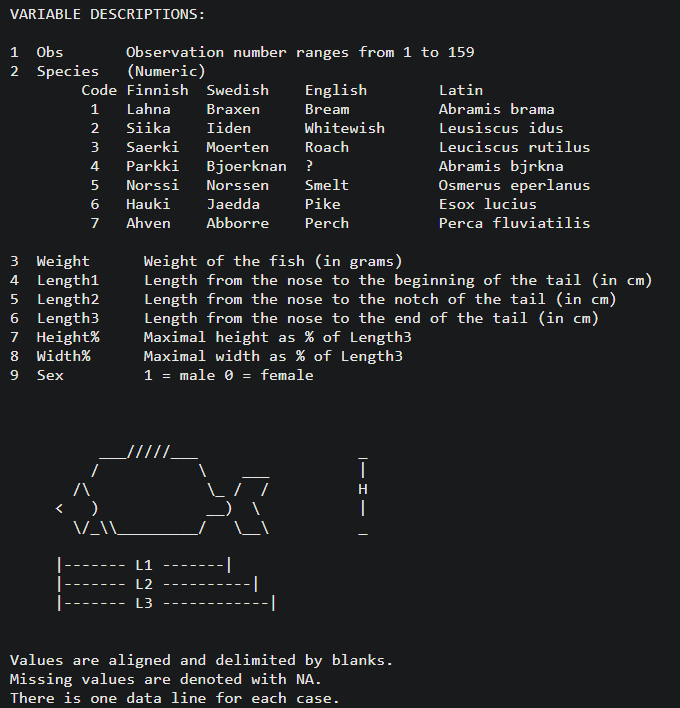

### 1. Assign Names to the Species
**Note**: Using Finnish name for ```Species=4```

In [3]:
fish_codes = {1:"Bream",2:"Whitewish", 3:"Roach", 4:"Parkki", 5:"Smelt", 6:"Pike", 7:"Perch"}

fish_data['Species'] =fish_data.Species.apply(lambda x: fish_codes[x])
fish_data.head(3)

,Species,Weight,Length1,Length2,Length3,Height%,Width%,Sex
0,Smelt,10.0,11.3,11.8,13.1,16.9,9.8,1.0
1,Perch,1000.0,39.8,43.0,45.2,26.4,16.1,0.0
2,Perch,145.0,22.0,24.0,25.5,25.0,15.0,NaN


In [4]:
fish_data.describe()

,Weight,Length1,Length2,Length3,Height%,Width%,Sex
count,158.000000,159.000000,159.000000,159.000000,159.000000,159.000000,72.000000
mean,398.695570,26.247170,28.415723,31.227044,28.313208,14.116352,0.236111
std,359.086204,9.996441,10.716328,11.610246,8.301122,2.274372,0.427672
min,0.000000,7.500000,8.400000,8.800000,14.500000,8.700000,0.000000
25%,120.000000,19.050000,21.000000,23.150000,24.250000,13.400000,0.000000
50%,272.500000,25.200000,27.300000,29.400000,27.100000,14.600000,0.000000
75%,650.000000,32.700000,35.500000,39.650000,37.600000,15.300000,0.000000
max,1650.000000,59.000000,63.400000,68.000000,44.500000,20.900000,1.000000


#### Remove Feature Sex
As from above, ```Sex``` has half of the labels missing.  
Let's remove ```Sex``` for now.

In [5]:
fish_data.drop(columns="Sex", inplace=True)

### 2. Feature Analysis

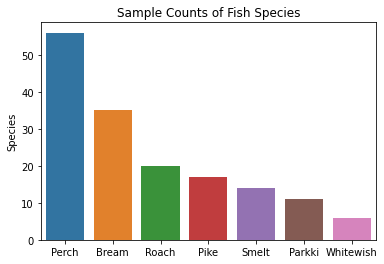

,Count,Proportion %
Perch,56,35.22
Bream,35,22.01
Roach,20,12.58
Pike,17,10.69
Smelt,14,8.81
Parkki,11,6.92
Whitewish,6,3.77


In [6]:
#Checking Species count
sp = pd.DataFrame(fish_data['Species'].value_counts())
sns.barplot(x=sp.index, y=sp["Species"])
plt.title("Sample Counts of Fish Species")
plt.show()

display(pd.DataFrame({
    "Count": fish_data['Species'].value_counts(),
    "Proportion %": (fish_data['Species'].value_counts() * 100/ fish_data.shape[0]).apply(lambda x: np.round(x, 2))
}, index=fish_data['Species'].value_counts().index))


We have very imbalanced samples here as author suggested. He had recorded more data on ```Species = Perch``` than others.

<AxesSubplot:>

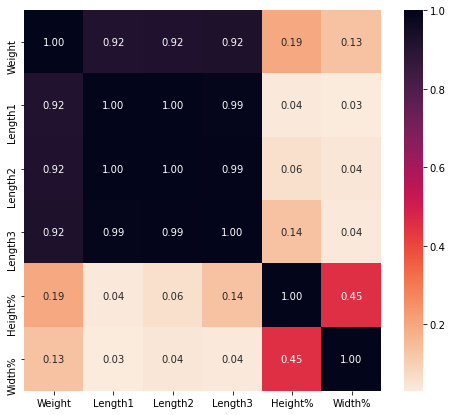

In [7]:
plt.figure(figsize=(8,7))
sns.heatmap(fish_data.corr(), annot=True, fmt=".2f", cmap="rocket_r")

So here ```Length1, Length2, Length3 ``` show a very high correlation with ```Weight``` as well as within them. So We'll possibly keep only one of them after checking for *Multicollinearity*.  
Also ```Weight``` distribution is Right Tailed.

Since author mentions that ```Height% and Weight%``` are relative to ```Length3```, we'll convert them back in units of ```Lenght3```.  

#### Added new features Height and Width

In [8]:
fish_data['Height'] = np.round(fish_data['Height%'] * fish_data['Length3'] / 100, 2)
fish_data['Width'] = np.round(fish_data['Width%'] * fish_data["Length3"] / 100, 2)

<AxesSubplot:>

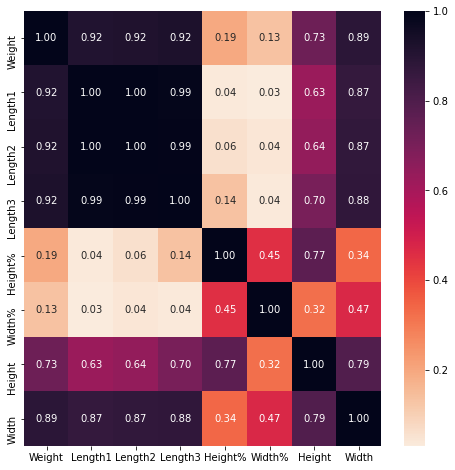

In [9]:
#Checking correlations again,
plt.figure(figsize=(8,8))
sns.heatmap(fish_data.corr(), annot=True, fmt=".2f", cmap="rocket_r")

Now we can see that ```Width``` and ```Height``` are pretty much correlated with ```Weight```.  

Also we'll keep an eye on ```Width``` for *multicollinearity*. 

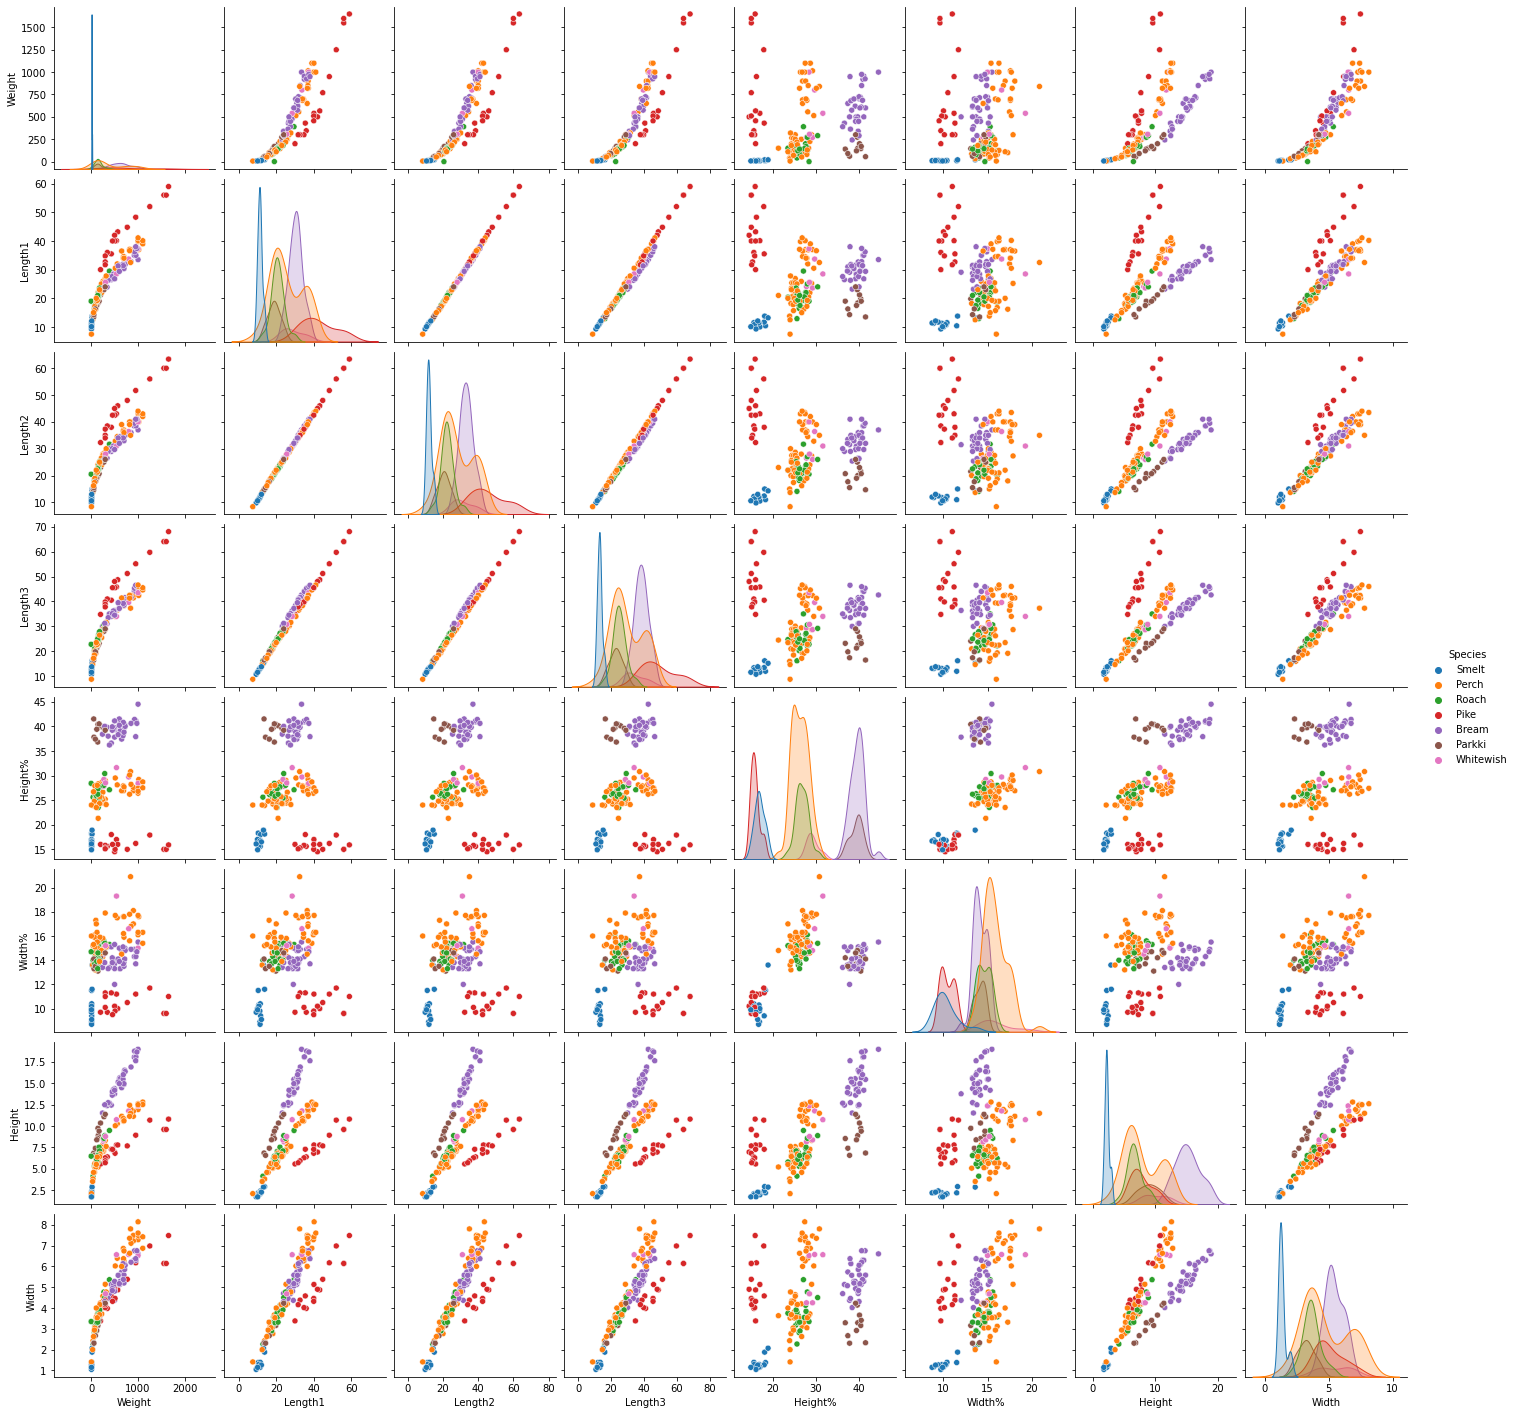

In [10]:
#Numerical Univariate and Pairwise analysis
sns.pairplot(fish_data, kind="scatter", hue="Species")
plt.show()

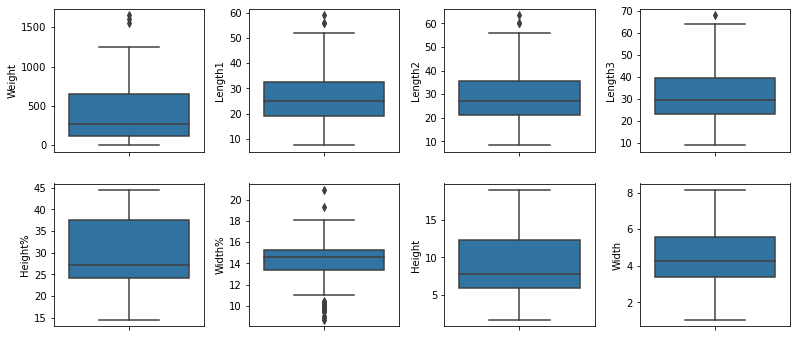

In [11]:
#Checking for feature distribution
fig,ax = plt.subplots(2, 4, figsize=(11,5))
fig.tight_layout()

for i, col in enumerate(fish_data.columns[1:]):
    sns.boxplot(y=col, data=fish_data, ax=ax[i//4, i%4])
plt.show()

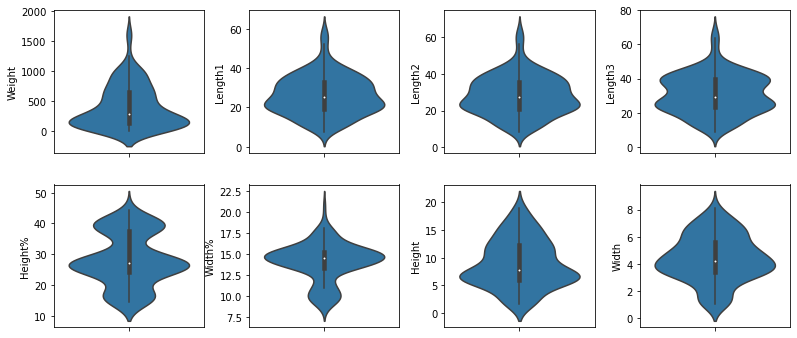

In [12]:
fig,ax = plt.subplots(2,4, figsize=(11,5))
fig.tight_layout()

for i, col in enumerate(fish_data.columns[1:]):
    sns.violinplot(y=col, data=fish_data, ax=ax[i//4, i%4])
    
plt.show()

#### Analyzing Outliers To Later Deal with

In [13]:
cols_for_outliers = ['Weight', 'Length1', 'Length2', 'Length3', "Width%"]

def check_for_outliers(column):
    col_df = fish_data[column]
    col_Q1 = col_df.quantile(0.25)
    col_Q3 = col_df.quantile(0.75)

    col_IQR = col_Q3 - col_Q1
    col_lowerend = col_Q1 - (1.5 * col_IQR)
    col_upperend = col_Q3 + (1.5 * col_IQR)

    #Spotting outliers
    print(f"=========== {column} ===========")
    display(col_df[(col_df < col_lowerend) | (col_df > col_upperend)])
    print()
    
print("Checking for Outliers:")
for col in cols_for_outliers:
    check_for_outliers(col)

Checking for Outliers:
=========== Weight ===========


17     1550.0
96     1600.0
158    1650.0
Name: Weight, dtype: float64


=========== Length1 ===========


17     56.0
96     56.0
158    59.0
Name: Length1, dtype: float64


=========== Length2 ===========


17     60.0
96     60.0
158    63.4
Name: Length2, dtype: float64


=========== Length3 ===========


158    68.0
Name: Length3, dtype: float64


=========== Width% ===========


0       9.8
17      9.6
18     10.0
26     10.2
31     10.3
35      9.7
46      9.4
49     10.4
66      9.8
79      8.9
81     20.9
88     10.0
95     10.5
96      9.6
103     8.7
104    10.2
112     9.7
113     9.1
116    10.1
124    19.3
125     9.7
150     9.9
157     9.5
Name: Width%, dtype: float64

##### Removing features ```Width%``` & ```Height%```
So rows ```17, 96``` and ```158``` are presumabaly our outliers. I'll Remove them after checking base model. Also we can see some outliers present in ```Width%``` column, but since we have already converted columns ```Width%``` and ```Height%``` to their proportionate values and the outliers were significantly gone now, we can remove them to avoid any noise.

In [14]:
fish_data.drop(columns=["Width%", "Height%"], inplace=True)

### 3. Handling Nan's

In [15]:
#Check for nulls
fish_data.isna().sum()[fish_data.isna().sum() > 0]

Weight    1
dtype: int64

In [16]:
fish_data[fish_data.Weight.isnull()]

,Species,Weight,Length1,Length2,Length3,Height,Width
119,Bream,NaN,29.5,32.0,37.3,13.91,5.07


Since ```Species = Bream``` is one of our majority features available, we can check ```Weight``` distribution for ```Bream``` and decide whether to impute a value for the missing weight of given observation and take risk of adding noise to our data or simply remove the observation 

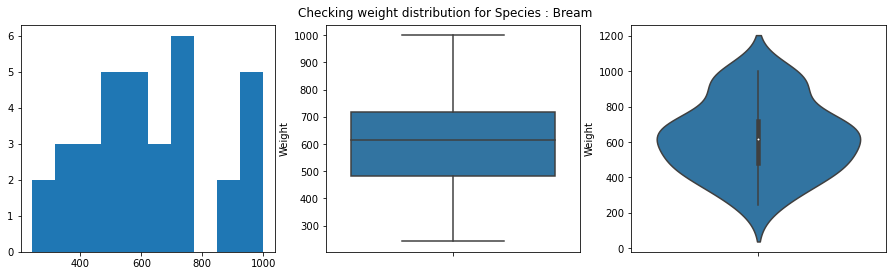

Bream Mean Weight:626.0 , Median Weight:615.0


In [17]:
fig,ax = plt.subplots(1, 3, figsize=(13,4))
fig.tight_layout( pad=2)

bream_df = fish_data[fish_data.Species == 'Bream']

ax[0].hist(bream_df.Weight)
sns.boxplot(y="Weight", data=bream_df, ax=ax[1])
sns.violinplot(y="Weight", data=bream_df, ax=ax[2])
fig.suptitle("Checking weight distribution for Species : Bream")
plt.show()

median_bream_wt = bream_df.Weight.median()
print(f"Bream Mean Weight:{bream_df.Weight.mean()} , Median Weight:{median_bream_wt}")

We can try replacing the null with Median Bream weight for now

In [18]:
fish_data.Weight.fillna(median_bream_wt, inplace=True)

fish_data.isna().sum() > 0 #Nulls have been removed now.

Species    False
Weight     False
Length1    False
Length2    False
Length3    False
Height     False
Width      False
dtype: bool

### 4. Model Building and Tuning
#### Model 1. Base OLS Multiple Regression (All Features)
Goal is to study impact of highly correlated independant variables on our prediction

In [19]:
scores = {}

In [20]:
base_cols = ['Species', 'Length1', 'Length2', 'Length3', 'Height', 'Width']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fish_data[base_cols], pd.to_numeric(fish_data['Weight']), test_size=0.2, random_state=10)

print(f"Train Shapes: X - {X_train.shape} , y - {np.shape(y_train)}")
print(f"Test Shapes: X - {X_test.shape} , y - {np.shape(y_test)}")

Train Shapes: X - (127, 6) , y - (127,)
Test Shapes: X - (32, 6) , y - (32,)


In [21]:
#Prepare data
#X = fish_data[['Species', 'Length1', 'Length2', 'Length3', 'Height%','Width%', 'Height', 'Width']]

#Add constant for OLS requirement
#X = sm.add_constant(X)

#y = pd.to_numeric(fish_data['Weight'])

#print(f"Shapes: X_train={X_train.shape}, y={np.shape(y_train)}")

We'll OneHotEncode ```Species``` and drop ```Species = Perch``` to avoid **dummy variable trap** and keep base the condition. 

In [22]:
X_train = pd.get_dummies(X_train, columns=["Species"])
X_train.drop(columns="Species_Perch", inplace=True)
X_train = sm.add_constant(X_train)

X_test = pd.get_dummies(X_test, columns=["Species"])
X_test.drop(columns="Species_Perch", inplace=True)
X_test = sm.add_constant(X_test)

print(f"Train Shapes: X={X_train.shape}, y={np.shape(y_train)}")
print(f"Test Shapes: X={X_test.shape}, y={np.shape(y_test)}")

Train Shapes: X=(127, 12), y=(127,)
Test Shapes: X=(32, 12), y=(32,)


In [23]:
base_reg = sm.OLS(y_train, X_train, hasconst=True)
base_result = base_reg.fit()
base_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     152.9
Date:                Sat, 22 Jan 2022   Prob (F-statistic):           3.27e-63
Time:                        06:38:02   Log-Likelihood:                -751.90
No. Observations:                 127   AIC:                             1528.
Df Residuals:                     115   BIC:                             1562.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -781.8097     46.014    -16.991      0.000    -872.955    -690.664
Length1             -73.9378     41.478     -1.783      0.077    -156.098       8.223
Length2              57.7896     50.299      1.149      0.253     -41.843     157.422
Length3              49.5438     31.391      1.578      0.117     -12.636     111.723
Height                3.7719     15.216      0.248      0.805     -26.367      33.911
Width                -8.3967     26.609     -0.316      0.753     -61.103      44.310
Species_Bream      -181.5132    134.279     -1.352      0.179    -447.493      84.467
Species_Parkki      -14.7444     77.465     -0.190      0.849    -168.188     138.699
Species_Pike       -384.2251     87.425     -4.395      0.000    -557.397    -211.053
Species_Roach       -74.8966     53.544     -1.399      0.165    -180.958      31.164
Species_Smelt       291.8105     47.347      6.163      0.000     198.025     385.596
Species_Whitewish   -46.8129     58.201     -0.804      0.423    -162.099      68.473
==============================================================================
Omnibus:                       42.553   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.991
Skew:                           1.330   Prob(JB):                     4.32e-23
Kurtosis:                       6.520   Cond. No.                     1.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

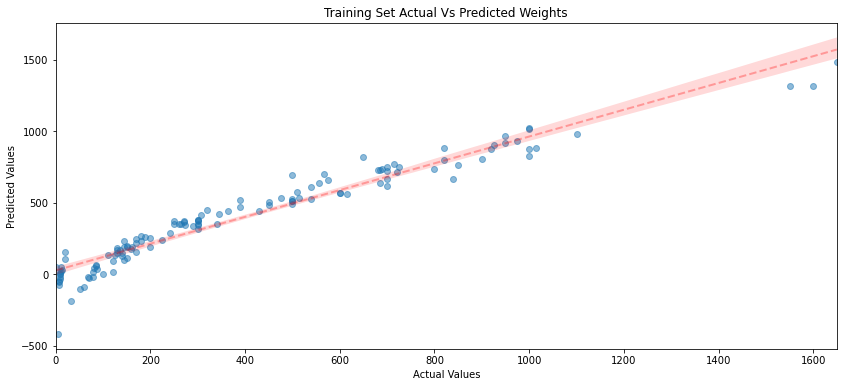

Pearson R: (0.9674765396281616, 1.7716865291807924e-76)


In [24]:
import scipy.stats as stats

#Base model prediction plot
plt.figure(figsize=(14,6))

sns.regplot(x=y_train, y=base_result.fittedvalues, 
           line_kws={
               'color':'r', 'alpha':0.3, 'linestyle':'--', 'linewidth':2
           },
            scatter_kws={ 'alpha':0.5})
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Training Set Actual Vs Predicted Weights")
plt.show()

print("Pearson R:", stats.pearsonr(base_result.fittedvalues, y_train))

##### Performance on Test Data

Text(0.5, 1.0, 'Test set Actual vs Predicted Weights ')

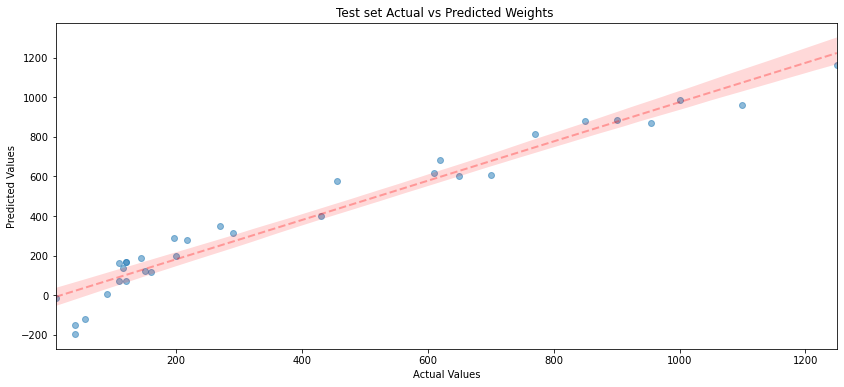

In [25]:
plt.figure(figsize=(14,6))

sns.regplot(x=y_test, y=base_result.get_prediction(X_test).summary_frame(alpha=0.05)['mean'],
           line_kws={
               'color':'r', 'alpha':0.3, 'linestyle':'--', 'linewidth':2
           },
            scatter_kws={
                'alpha':0.5
            }
           )

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Test set Actual vs Predicted Weights ")

In [26]:
from sklearn.metrics import mean_squared_error
scores["base"] = {"train":(np.sqrt(mean_squared_error(y_train, base_result.fittedvalues)), base_result.rsquared),
                 "test":(np.sqrt(mean_squared_error(y_test, base_result.get_prediction(X_test).summary_frame(alpha=0.05)['mean'])),base_result.rsquared)}

After applying OLS for features ```Length1```, ```Length2```, ```Length3```, ```Height%```, ```Width%```, ```Height```, ```Width```,
       ```Species_Bream```, ```Species_Parkki```, ```Species_Pike```, ```Species_Roach```,
       ```Species_Smelt```, ```Species_Whitewish```, we can see $R^2 = 0.936$ which model is able to explain 93.6% of the variation.  
       
I will treat this as baseline. Some of the features have ${P-value > 0.05}$ and thus insignificant. I'll also perform feature selection to get a model that keeps variation in our data and removes noise.   
Also I will account for **Multicollinearity**, **Hetroscedasticity** of residuals and **Normality** of residuals. Also there's indication of high skewness.  

##### Multicollinearity  

I'll apply **Variance Inflation Factor**, which tried to find how much of variation in selected variable is explained by remaining other variables. High VIF suggests presence of Multicollinearity.

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame([[col, variance_inflation_factor(X_train.values, X_train.columns.get_loc(col))] for col in X_train.columns]
            , index=range(X_train.shape[1]), columns=["Variables", "VIF"]).sort_values('VIF', ascending=False)

,Variables,VIF
2,Length2,4048.420080
1,Length1,2395.205662
3,Length3,1868.858648
4,Height,62.531345
6,Species_Bream,46.029016
0,const,29.958550
5,Width,29.104600
8,Species_Pike,9.252827
7,Species_Parkki,4.421996
9,Species_Roach,4.225341


So **VIF** ${ > 10}$ shows that our features display strong multicollinearity. Let's remove features with high VIF one by one post recomputing VIF and get the best possible outcome to our model.

```Python
Baseline Features- ['Length1', 'Length2', 'Length3', 'Height', 'Width', 'Species_Bream','Species_Parkki', 'Species_Pike', 'Species_Roach', 'Species_Smelt','Species_Whitewish']
```

#### Model 2. Improved Model V1

In [28]:
selected_cols = [ 'Length1',  'const',  'Species_Bream',  'Species_Pike', 'Species_Smelt' ]

X_temp = X_train[selected_cols]

pd.DataFrame([[col, variance_inflation_factor(X_temp.values, X_temp.columns.get_loc(col))] for col in selected_cols]
            , index=range(len(selected_cols)), columns=["Variables", "VIF"]).sort_values('VIF', ascending=False)

,Variables,VIF
1,const,15.699236
0,Length1,2.319151
3,Species_Pike,1.784548
4,Species_Smelt,1.427011
2,Species_Bream,1.222524


In [29]:
reg_v1 = sm.OLS(y_train, X_train[selected_cols], hasconst=True)
reg_v1_summary = reg_v1.fit()
reg_v1_summary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     392.0
Date:                Sat, 22 Jan 2022   Prob (F-statistic):           1.33e-68
Time:                        06:38:02   Log-Likelihood:                -759.55
No. Observations:                 127   AIC:                             1529.
Df Residuals:                     122   BIC:                             1543.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Length1          42.3373      1.331     31.811      0.000      39.703      44.972
const          -708.1193     34.348    -20.616      0.000    -776.115    -640.123
Species_Bream    47.4509     22.566      2.103      0.038       2.780      92.122
Species_Pike   -366.4600     39.591     -9.256      0.000    -444.834    -288.086
Species_Smelt   241.4022     34.163      7.066      0.000     173.773     309.032
==============================================================================
Omnibus:                       29.697   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.618
Skew:                           1.050   Prob(JB):                     3.75e-12
Kurtosis:                       5.353   Cond. No.                         161.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So after several manual iterations, I found best feature combination that preserves most variance of the model and also keeps significant features with multicollinearity removed.
```Python
Best Features - [ 'Length1',  'const',  'Species_Bream',  'Species_Pike', 'Species_Smelt' ]
```
Best Feature stats: ${R^2 = 0.928}$  

Note that we had to remove features specifying below species, which we need for our final interpretation. 
```Python 
    Species = ['Bream', 'Whitewish', 'Roach', 'Parkki']  
```
**TODO:** I'll later try to introduce some *Interaction Terms* and/or *NonLinear Transformations* to get proper relations.

##### Are Residuals Normally Distributed?

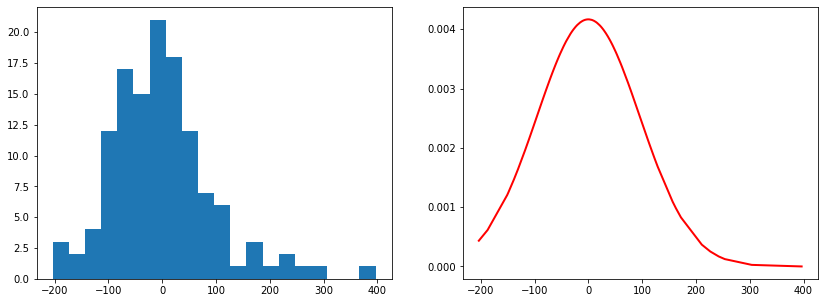

In [30]:
mu , sigma = np.mean(reg_v1_summary.resid), np.std(reg_v1_summary.resid)
pdf = stats.norm.pdf(sorted(reg_v1_summary.resid), mu, sigma)

fig,ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(reg_v1_summary.resid, bins=20)
ax[1].plot(sorted(reg_v1_summary.resid), pdf, color='r', linewidth=2)

plt.show()

Distribution of Residuals does not follow normal distribution perfectly with ```skew = 0 , excess kurtosis = 0```. There are small number of outliers to the right and the tail is a bit fatter, that explains distribution has ```kurtosis = 5```.  

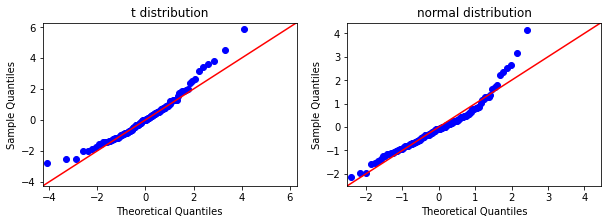

In [31]:
# QQplot
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,3))
sm.qqplot(reg_v1_summary.resid, stats.t, fit=True, line='45', ax = ax1)
ax1.set_title("t distribution")

sm.qqplot(reg_v1_summary.resid, stats.norm, fit=True, line='45', ax=ax2)
ax2.set_title("normal distribution")
plt.show()

Seems like model follows normal distribution better than t-distribution with some outliers. We'll check this later post adding new variables and retraining.

##### Hetroscedasticity

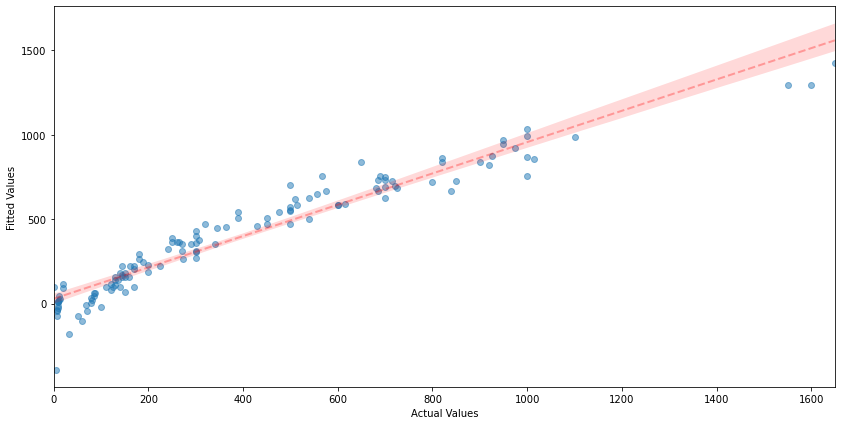

Pearson R: (0.9632327349005384, 3.3165700943829495e-73)


In [32]:
plt.figure(figsize=(14,7))

sns.regplot(x=y_train, y=reg_v1_summary.fittedvalues, 
           line_kws={
               'color':'r', 'alpha':0.3, 'linestyle':'--', 'linewidth':2
           },
            scatter_kws={ 'alpha':0.5})
plt.xlabel("Actual Values")
plt.ylabel("Fitted Values")
plt.show()

print("Pearson R:", stats.pearsonr(reg_v1_summary.fittedvalues, y_train))

Consistent with our reported ${R^2}$. Although we can see some weights have been reported in negative, which is completely wrong judgement. We'll have to find out the root cause.

##### Performance on Test Data

Text(0.5, 1.0, 'Test set Actual vs Predicted Weights ')

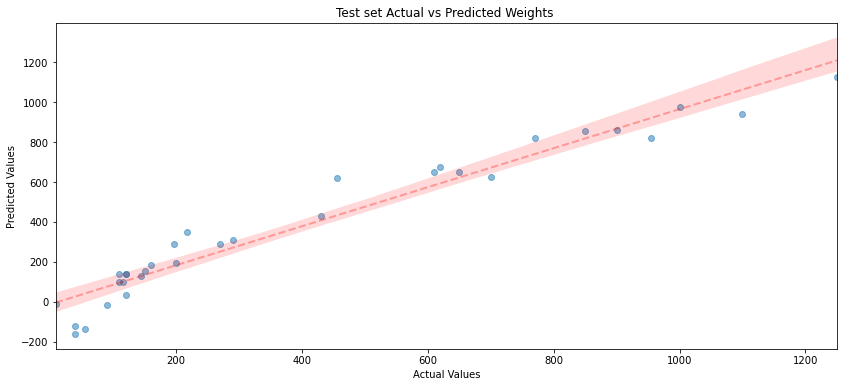

In [33]:
plt.figure(figsize=(14,6))

sns.regplot(x=y_test, y=reg_v1_summary.get_prediction(X_test[selected_cols]).summary_frame(alpha=0.05)['mean'],
           line_kws={
               'color':'r', 'alpha':0.3, 'linestyle':'--', 'linewidth':2
           },
            scatter_kws={
                'alpha':0.5
            }
           )

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Test set Actual vs Predicted Weights ")

Model still seems to have irregular error for fish with lower weights.  

##### Fitting Line on Residuals
Let's now visualize strength of the correlation between predicted and actual weights by fitting a line on Residuals vs Actual weights.

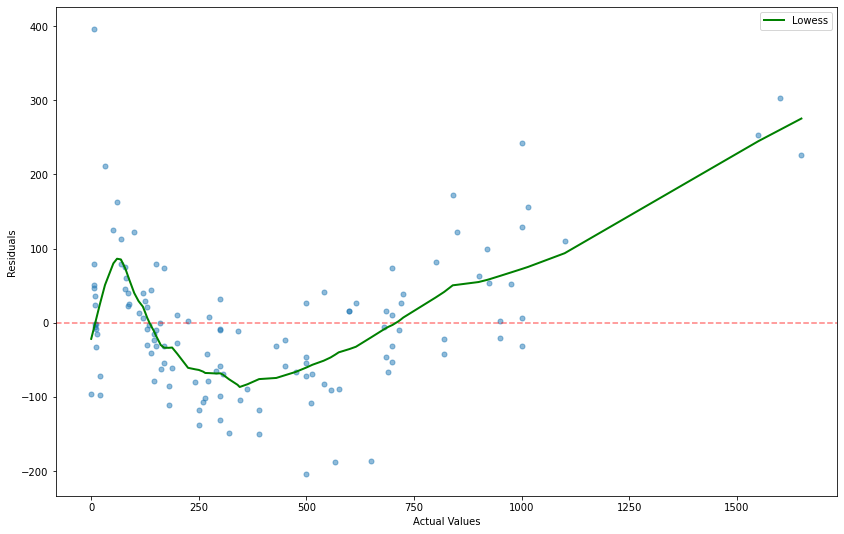

Pearson R: (0.2686683800078269, 0.002256903956269464)


In [34]:
from statsmodels.nonparametric.smoothers_lowess import lowess

ys = lowess(reg_v1_summary.resid.values, y_train, frac=0.2)
ys = pd.DataFrame(ys, index=range(len(ys)), columns=['a', 'b'])
ys = ys.sort_values(by='a')

fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(y_train, reg_v1_summary.resid, alpha=0.5, s=25)
plt.axhline(y=0, color='r', linestyle="--", alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")

plt.plot(ys.a, ys.b, c='green', linewidth=2, label="Lowess")
plt.legend()
plt.show()
print("Pearson R:", stats.pearsonr(y_train, reg_v1_summary.resid))

As we can see, the model tends to overestimate fishes with smaller and larger weights along with the fact that weights are negative.  

##### Checking Patterns/Trends in Residuals

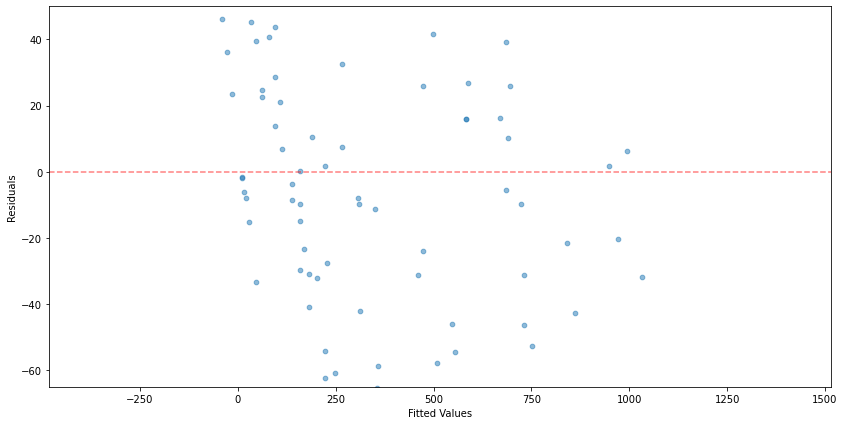

In [35]:
# plot actual values versus residuals
plt.figure(figsize=(14,7))

plt.scatter(y=reg_v1_summary.resid, x=reg_v1_summary.fittedvalues, alpha=0.5, s=22)
plt.axhline(y=0, color='r', linestyle="--", alpha=0.5)

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.ylim(-65, 50)
plt.show()

In [36]:
scores["model_v1"] = {"train":(np.sqrt(mean_squared_error(y_train, reg_v1_summary.fittedvalues)), reg_v1_summary.rsquared),
                 "test":(np.sqrt(mean_squared_error(y_test, reg_v1_summary.get_prediction(X_test[selected_cols]).summary_frame(alpha=0.05)['mean'])),reg_v1_summary.rsquared)}

Above plot shows that residuals are widely distributed and no pattern\trend seems to present.  

#### Model 3. Retry For Model V2 After Dealing with Outliers  
Since we still know the indexes, we'll check our previously noticed outliers viz. ```Rows = 17, 96, 158```

In [37]:
outlier_idx = [17,96,158]
X_train.loc[outlier_idx]

,const,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Pike,Species_Roach,Species_Smelt,Species_Whitewish
17,1.0,56.0,60.0,64.0,9.60,6.14,0,0,1,0,0,0
96,1.0,56.0,60.0,64.0,9.60,6.14,0,0,1,0,0,0
158,1.0,59.0,63.4,68.0,10.81,7.48,0,0,1,0,0,0


In [38]:
#Removing above rows,
X_train.drop(outlier_idx, inplace=True)
y_train.drop(outlier_idx, inplace=True)

In [39]:
#Checking VIFs
selected_cols = [ 'Length1','Height',  'const',  'Species_Bream',  'Species_Pike', 'Species_Smelt' ]

X_temp = X_train[selected_cols]

pd.DataFrame([[col, variance_inflation_factor(X_temp.values, X_temp.columns.get_loc(col))] for col in selected_cols]
            , index=range(len(selected_cols)), columns=["Variables", "VIF"]).sort_values('VIF', ascending=False)

,Variables,VIF
1,Height,19.212672
2,const,17.599462
0,Length1,9.686691
3,Species_Bream,6.370474
4,Species_Pike,3.464805
5,Species_Smelt,1.715325


In [40]:
#Retrain model
reg_v2 = sm.OLS(y_train, X_train[selected_cols], hasconst=True)
reg_v2_summary = reg_v2.fit()
reg_v2_summary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     364.6
Date:                Sat, 22 Jan 2022   Prob (F-statistic):           5.69e-70
Time:                        06:38:04   Log-Likelihood:                -712.53
No. Observations:                 124   AIC:                             1437.
Df Residuals:                     118   BIC:                             1454.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Length1          28.9639      2.471     11.722      0.000      24.071      33.857
Height           32.5305      6.917      4.703      0.000      18.833      46.228
const          -641.2231     29.249    -21.923      0.000    -699.145    -583.301
Species_Bream  -108.4208     41.091     -2.639      0.009    -189.793     -27.049
Species_Pike   -228.5535     50.022     -4.569      0.000    -327.610    -129.497
Species_Smelt   253.1053     29.808      8.491      0.000     194.078     312.133
==============================================================================
Omnibus:                       39.821   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.408
Skew:                           1.275   Prob(JB):                     5.21e-21
Kurtosis:                       6.402   Cond. No.                         243.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Are Residuals Normally Distributed?

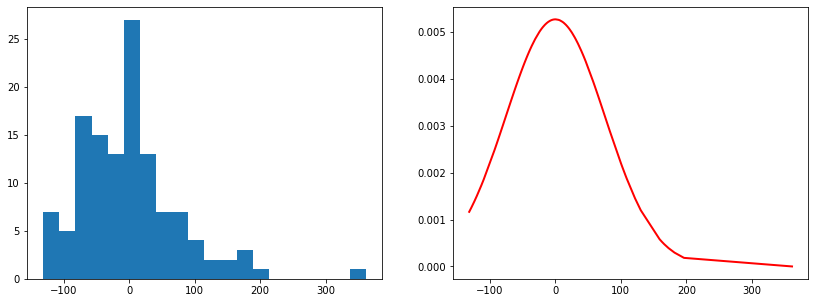

In [41]:
mu , sigma = np.mean(reg_v2_summary.resid), np.std(reg_v2_summary.resid)
pdf = stats.norm.pdf(sorted(reg_v2_summary.resid), mu, sigma)

fig,ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(reg_v2_summary.resid, bins=20)
ax[1].plot(sorted(reg_v2_summary.resid), pdf, color='r', linewidth=2)

plt.show()

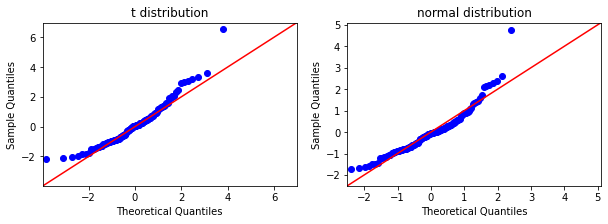

In [42]:
# QQplot
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,3))
sm.qqplot(reg_v2_summary.resid, stats.t, fit=True, line='45', ax = ax1)
ax1.set_title("t distribution")

sm.qqplot(reg_v2_summary.resid, stats.norm, fit=True, line='45', ax=ax2)
ax2.set_title("normal distribution")
plt.show()

##### Hetroscedasticity

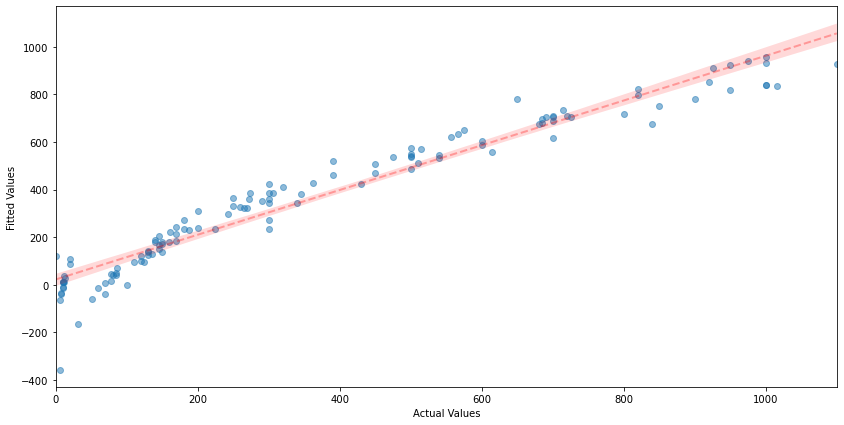

Pearson R: (0.9691249355622067, 4.875440101458597e-76)


In [43]:
plt.figure(figsize=(14,7))

sns.regplot(x=y_train, y=reg_v2_summary.fittedvalues, 
           line_kws={
               'color':'r', 'alpha':0.3, 'linestyle':'--', 'linewidth':2
           },
            scatter_kws={ 'alpha':0.5})
plt.xlabel("Actual Values")
plt.ylabel("Fitted Values")
plt.show()

print("Pearson R:", stats.pearsonr(reg_v2_summary.fittedvalues, y_train))

##### Performance on Test Data

Text(0.5, 1.0, 'Test set Actual vs Predicted Weights ')

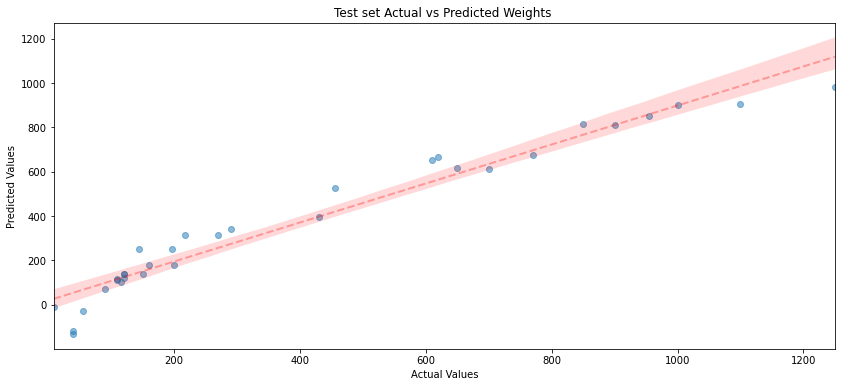

In [44]:
plt.figure(figsize=(14,6))

sns.regplot(x=y_test, y=reg_v2_summary.get_prediction(X_test[selected_cols]).summary_frame(alpha=0.05)['mean'],
           line_kws={
               'color':'r', 'alpha':0.3, 'linestyle':'--', 'linewidth':2
           },
            scatter_kws={
                'alpha':0.5
            }
           )

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Test set Actual vs Predicted Weights ")

##### Fitting Line on Residuals

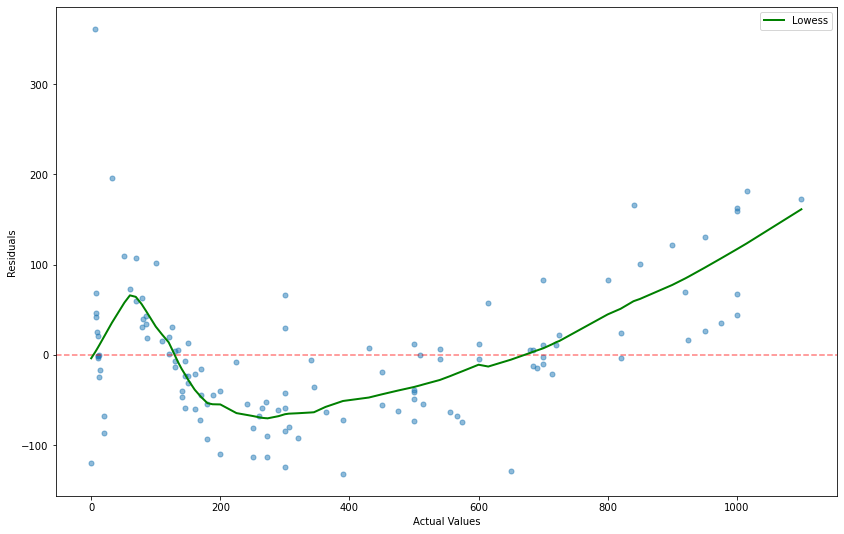

Pearson R: (0.24657019136858552, 0.005768826645191295)


In [45]:
ys = lowess(reg_v2_summary.resid.values, y_train, frac=0.2)
ys = pd.DataFrame(ys, index=range(len(ys)), columns=['a', 'b'])
ys = ys.sort_values(by='a')

fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(y_train, reg_v2_summary.resid, alpha=0.5, s=25)
plt.axhline(y=0, color='r', linestyle="--", alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")

plt.plot(ys.a, ys.b, c='green', linewidth=2, label="Lowess")
plt.legend()
plt.show()
print("Pearson R:", stats.pearsonr(y_train, reg_v2_summary.resid))

We did manage to handle impact due to outliers especially on fish with higher weights. But for lower weights, our estimates are still bad.

In [46]:
scores["model_v2"] = {"train":(np.sqrt(mean_squared_error(y_train, reg_v2_summary.fittedvalues)), reg_v2_summary.rsquared),
                 "test":(np.sqrt(mean_squared_error(y_test, reg_v2_summary.get_prediction(X_test[selected_cols]).summary_frame(alpha=0.05)['mean'])),reg_v2_summary.rsquared)}

In [57]:
scores_df = pd.DataFrame(scores).apply(lambda x: (np.round(x[0], 2), np.round(x[1], 2)))
scores_df.rename(columns={"base":"base (RMSE, Rsq)", "model_v1":"model_v1 (RMSE, Rsq)", "model_v2":"model_v2 (RMSE, Rsq)"})

,"base (RMSE, Rsq)","model_v1 (RMSE, Rsq)","model_v2 (RMSE, Rsq)"
train,"[90.15, 0.94]","[95.75, 0.93]","[75.74, 0.94]"
test,"[85.32, 0.94]","[88.74, 0.93]","[89.71, 0.94]"
